In [1]:
import pandas as pd

from pandas.core.frame import DataFrame
from pandas.core.series import Series

data_frame: DataFrame = pd.read_csv(r'./Courses_Berkeley_2018-01-15.csv', encoding='latin1')

#Unique Courses
data_frame = data_frame.drop_duplicates(subset=['Name'], keep='last')

#Description is null
data_frame = data_frame.dropna(subset=["Description"])

#Description too short
data_frame = data_frame[data_frame['Description'].map(len) > 20]


print(data_frame)

        Year              Field  \
8       2011      Public Health   
14      1977  Aerospace Studies   
15      1977  Aerospace Studies   
17      1978  Aerospace Studies   
18      1978  Aerospace Studies   
...      ...                ...   
305662  1970            Biology   
305663  1968            Zoology   
305665  1969            Zoology   
305667  1918        Agriculture   
305668  1917        Agriculture   

                                                     Name       Number  \
8         Statistical Analysis of Continuous Outcom- Data          145   
14                          United Slates Air Force Today     1A-1B-1C   
15                 The Developmental Qrowtti of Air Power  21A-21B-21C   
17                     Introduction to Aerospace Studies             1   
18                               The military Force Today            2   
...                                                   ...          ...   
305662    Introduction to the Science of Living Organisms    

In [30]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


lemmatizer: WordNetLemmatizer = WordNetLemmatizer()
stemmer : PorterStemmer = PorterStemmer()
sw_nltk = set(stopwords.words("english"))

descriptions: Series = data_frame['Description']


custom_stop_words: set = ("part", "class", "course", "one", "two", "three", "four", "discussion", "lecture", "hour", "day","month","semester","week","sophomore","junior",
"senior","fresh","seminar","exam","required","summer","winter","student","pre","requisite","prerequisite","lecture","introduction","introduces","essay","notes","textbook",
"etc","covering","sp","credit","pr","fsp","info","session","read","basic","hard","emphasis","form","primary","understand","learn","discus","learning","general","concept","study",
"overciew","focus","emphasize","presented","learning","seminar","proseminar","topic","major","year","distinguished", "presentation",
"hour", "concept","hours", "per", "week", "weeks","year", "years", "month", "day", "days", "definition", "define", "elaborate", "fwsp")

stopwords_removed_description: list = []

i = 0
    
for index, value in descriptions.iteritems():
    text = str(value).lower()
    text = re.sub('(\\d|\\W)+',' ',text)
    text = re.sub('[\(\)]', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = word_tokenize(text)
    text = [word for word in text if not word in sw_nltk]
    text = [word for word in text if not word in custom_stop_words]
    
    nouns_text:list = []
    for word, pos in nltk.pos_tag(text):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns_text.append(word)
    
    text = nouns_text
    text = [lemmatizer.lemmatize(word) for word in text]
    #text = [stemmer.stem(word) for word in text]
    
    stopwords_removed_description.append((' ').join(text))

In [31]:
#Verifying the length of output
print(len(stopwords_removed_description))

52275


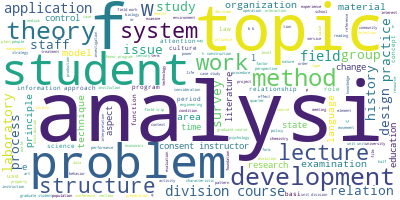

In [265]:
# Analyzing processed corpus

from wordcloud import WordCloud

long_string = ','.join(stopwords_removed_description)

wordcloud = WordCloud(background_color="white", max_words=1000000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()

In [54]:
# BoW -> Bag Of Words

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(stopwords_removed_description)

vectorized_descriptions = vectorizer.transform(stopwords_removed_description)

print(vectorized_descriptions.shape)

['laboratory regression model outcome data square property coefficient prediction model model assumption transformation outlier point variable interaction si covariance correlation correlation method com analysis variance facto model test assumption comparison effect model health component measure model', 'defines role structure category force air force dynamic instrumentofnationalpower camacho', 'trace air power concept application identifies change evolution seek impact development air superiority concept', 'air force rotc program survey state air preview study course cadet commission force comacho f', 'investigation structure state air force structure air force organization malor command']
(52275, 55049)


In [176]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

labelencoder = LabelEncoder()

labels = data_frame['Area'].values

labelencoder.fit(labels)    

encoded_labels = labelencoder.transform(labels)

categorical_labels = tf.keras.utils.to_categorical(encoded_labels)

print(len(data_frame['Area'].unique()))
print(encoded_labels.shape)
print(encoded_labels[120])
print(len(categorical_labels))
print(categorical_labels.shape)

90
(52275,)
34
52275
(52275, 90)


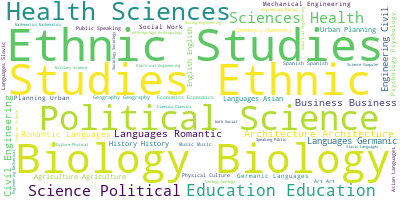

In [269]:
# Analyzing processed labels

from wordcloud import WordCloud

long_string_labels = ','.join(labels)

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string_labels)

wordcloud.to_image()

In [206]:
# Training model

from keras.models import Sequential
from keras import layers

input_dim = vectorized_descriptions.shape[1]  

model = Sequential()
model.add(layers.Dense(90, input_dim = input_dim, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(90, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 90)                4954500   
                                                                 
 dense_1 (Dense)             (None, 120)               10920     
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 90)                10890     
                                                                 
Total params: 4,990,830
Trainable params: 4,990,830
Non-trainable params: 0
_________________________________________________________________


In [207]:
from keras.backend import clear_session
clear_session()

history = model.fit(vectorized_descriptions,
                    categorical_labels, 
                    epochs=200, 
                    verbose=False, 
                    batch_size=2000)

In [208]:
accuracy = model.evaluate(vectorized_descriptions, categorical_labels, verbose=False)

print(f"Training Accuracy: {accuracy}")

Training Accuracy: 0.1486382782459259


In [428]:
test_case_one = '''
This course introduces fundamental concepts in Automata theory and formal languages including grammar, 
finite automaton, regular expression, formal language, pushdown automaton and Turing machine. Not only do 
they form basic models of computation, they are also the foundation of many branches of computer science, 
e.g. compilers, programming languages, concurrent systems, etc. The properties of these models will be studied 
using various rigorous techniques for analyzing and comparing them, by using both formalism and examples.
'''


text = str(test_case_one).lower()
text = re.sub('(\\d|\\W)+',' ',text)
text = re.sub('[\(\)]', ' ', text)
text = re.sub('[^a-zA-Z]', ' ', text)
text = word_tokenize(text)
text = [word for word in text if not word in sw_nltk]
text = [word for word in text if not word in custom_stop_words]
    
# nouns_text:list = []
# for word, pos in nltk.pos_tag(text):
#     if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
#         nouns_text.append(word)
    
# text = nouns_text
text = [lemmatizer.lemmatize(word) for word in text]
text = (' ').join(text)

print(text)

fundamental concept automaton theory formal language including grammar finite automaton regular expression formal language pushdown automaton turing machine model computation also foundation many branch computer science e g compiler programming language concurrent system property model studied using various rigorous technique analyzing comparing using formalism example


In [429]:
# LDA for similar word grouping

import gensim
import gensim.corpora as corpora
from pprint import pprint

tokens_array = text.split(' ')
print(tokens_array)

# Gensim BoW
id2word = corpora.Dictionary([tokens_array])

# TDF
corpus = [id2word.doc2bow(token) for token in [tokens_array]]

print(corpus[:1][0][:30])


num_topics = 4

# LDA Base Model
lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = num_topics,
                                       random_state=1000)


all_lda_topics = lda_model.print_topics()
all_lda_topics_keywords: list = []

for i in range(len(all_lda_topics)):
    topic_keywords_array: list = [] 
    
    str_keywords = all_lda_topics[i][1]
    str_keywords = str_keywords.split('+')
    
    for j in range(len(str_keywords)):
        keyword = str(str_keywords[j]);
        keyword = re.sub('(\\d|\\W)+','',keyword)
        topic_keywords_array.append(keyword)
    
    all_lda_topics_keywords.append(topic_keywords_array)
    topics_keywords_array = []

    
pprint(all_lda_topics)    
pprint(all_lda_topics_keywords)

['fundamental', 'concept', 'automaton', 'theory', 'formal', 'language', 'including', 'grammar', 'finite', 'automaton', 'regular', 'expression', 'formal', 'language', 'pushdown', 'automaton', 'turing', 'machine', 'model', 'computation', 'also', 'foundation', 'many', 'branch', 'computer', 'science', 'e', 'g', 'compiler', 'programming', 'language', 'concurrent', 'system', 'property', 'model', 'studied', 'using', 'various', 'rigorous', 'technique', 'analyzing', 'comparing', 'using', 'formalism', 'example']
[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
[(0,
  '0.049*"language" + 0.046*"automaton" + 0.038*"using" + 0.034*"model" + '
  '0.032*"formal" + 0.028*"grammar" + 0.027*"e" + 0.026*"analyzing" + '
  '0.026*"computer" + 0.025*"expression"'),
 (1,
  '0.049*"language" + 0.040*"

In [430]:
text_array = []
text_array.append(text)

vectorized_test_case = vectorizer.transform(text_array)
print(vectorized_test_case.shape)

(1, 55049)


In [446]:
# Prediction Of Parent Class

import numpy as np

predicted_class = model.predict(vectorized_test_case) 
classes_x = np.argmax(predicted_class,axis=1)

print(predicted_class)
print(classes_x)
print((model.predict(vectorized_test_case) > 0.5).astype("int32"))
prediction = ''

# print(labels[39])
# print(data_frame['Description'].values[39])

for i in range(len(encoded_labels)):
    if encoded_labels[i] == classes_x[0]:
        print(f'\n\nThe classified class = {labels[i]}')
        prediction = labels[i]
        break

[[4.94540231e-35 9.09586620e-31 5.94467945e-16 3.63259081e-32
  1.12876971e-29 1.53551136e-37 7.79073311e-25 4.30262429e-36
  0.00000000e+00 1.29250153e-31 1.70163711e-27 4.82657924e-12
  2.62900316e-17 2.21036998e-21 6.14034082e-22 1.75037398e-11
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.41391743e-14
  5.13384163e-34 0.00000000e+00 0.00000000e+00 6.14854156e-23
  7.48880225e-29 2.33680898e-20 5.79935592e-31 7.60833966e-04
  2.59212421e-12 9.90631426e-34 2.77515638e-20 1.22657644e-38
  8.17354014e-15 3.97218398e-26 1.21637386e-20 0.00000000e+00
  2.48395732e-33 1.85404088e-28 9.95190264e-22 0.00000000e+00
  3.85673449e-26 6.07161067e-28 0.00000000e+00 0.00000000e+00
  3.71351418e-27 2.45902160e-10 0.00000000e+00 0.00000000e+00
  7.23602860e-37 1.48892200e-29 0.00000000e+00 6.43377505e-28
  0.00000000e+00 1.21349820e-31 1.98032501e-31 7.61916494e-36
  5.06785691e-35 4.25762079e-31 1.78086611e-05 8.99809122e-17
  1.21361088e-10 1.86282264e-30 3.42927578e-15 4.85029332e-02
  0.0000

In [432]:
# Classifying sub topics using results of LDA

# Vectorizing
vectorized_sub_test_cases: list = []
    
new_keywords_one = list(set(all_lda_topics_keywords[0])^set(all_lda_topics_keywords[1]))
new_keywords_two = list(set(all_lda_topics_keywords[2])^set(all_lda_topics_keywords[3]))
print(new_keywords_one)
print(new_keywords_two)

sub_class_keywords_array = [new_keywords_one, new_keywords_two]
    
for i in range(len(sub_class_keywords_array)):
    keywords_string = ' '.join(sub_class_keywords_array[i])
    vectorized_sub_test_cases.append(vectorizer.transform([keywords_string]))
    
print(vectorized_sub_test_cases[1].shape)

for i in range(len(vectorized_sub_test_cases)):
    sub_topic_class = model.predict(vectorized_sub_test_cases[i])
    class_decoded = np.argmax(predicted_class,axis=1)
    for j in range(len(encoded_labels)):
        if encoded_labels[j] == classes_x[0]:
            print(f'\n\nThe classified class = {labels[j]}')
            break
    

['regular', 'grammar', 'analyzing', 'e', 'compiler', 'concept']
['pushdown', 'system', 'property', 'computation', 'machine', 'example', 'turing', 'formalism', 'e', 'computer']
(1, 55049)


The classified class = Other Engineering


The classified class = Other Engineering


In [452]:
# furher classification of sub classes
from text_mining import preprocessing_test_cases

from skill_keywords import lookup_table
from skillcodes import tags_table

test_case_processed_one = sub_class_keywords_array[0]
test_case_processed_two = sub_class_keywords_array[1]

def get_key(val):
    for key, value in tags_table.items():
        if val == value:
            return key
    return "key doesn't exist"

def compare(list_corpus, list_comparable, key):
    list_corpus_set = set(list_corpus)
    intersection = list_corpus_set.intersection(list_comparable)

    intersection_list = list(intersection)

    similarity = ( len(intersection) / len(list_corpus_set) ) * 100 

    if len(intersection_list) > 2 and similarity > 1:
        print(f'\nSimilar keywords -> {intersection_list} \nContent Coverage -> {round(similarity,2)} %\nSimilar Class -> {get_key(int(key))}\n')


for key in lookup_table:
    compare(lookup_table[key], test_case_processed_one, key)
    compare(lookup_table[key], test_case_processed_two, key)


Similar keywords -> ['system', 'machine', 'computer'] 
Content Coverage -> 15.79 %
Similar Class -> analysis and design for automated manufacturing


Similar keywords -> ['system', 'property', 'computer'] 
Content Coverage -> 7.5 %
Similar Class -> neurobiology laboratory


Similar keywords -> ['system', 'property', 'computer'] 
Content Coverage -> 10.0 %
Similar Class -> computational methods in chemical engineering 


Similar keywords -> ['system', 'property', 'example'] 
Content Coverage -> 11.54 %
Similar Class -> applied chemical thermodynamics


Similar keywords -> ['system', 'property', 'example'] 
Content Coverage -> 9.09 %
Similar Class -> applied chemical thermodynamics   three hours of lecture djscussion per week


Similar keywords -> ['system', 'property', 'computer'] 
Content Coverage -> 12.0 %
Similar Class -> introduction to chemical process analysis  three hours of lecture  


Similar keywords -> ['system', 'machine', 'computer'] 
Content Coverage -> 2.4 %
Similar Clas



Similar keywords -> ['system', 'property', 'machine', 'turing'] 
Content Coverage -> 11.43 %
Similar Class -> advanced graduate study in computer science 


Similar keywords -> ['system', 'computer', 'example'] 
Content Coverage -> 8.11 %
Similar Class -> object  oriented data systems for industrial and commerical applications


Similar keywords -> ['system', 'computer', 'example'] 
Content Coverage -> 3.06 %
Similar Class -> teaching techniques for electrical engineering 


Similar keywords -> ['system', 'computer', 'example'] 
Content Coverage -> 2.65 %
Similar Class -> teaching techniques for electrical


Similar keywords -> ['system', 'computer', 'example'] 
Content Coverage -> 2.88 %
Similar Class -> teachingtechniquesfor electrical engi neering


Similar keywords -> ['property', 'computation', 'example'] 
Content Coverage -> 4.48 %
Similar Class -> developing children  mathematical cog  nition


Similar keywords -> ['system', 'property', 'example'] 
Content Coverage -> 14.29 %


In [434]:
for i in range(len(encoded_labels)):
    if(encoded_labels[i] == predicted_class[0][0]):
        print(f"{i}")

In [92]:
print(data_frame["Name"].values[10142])

 22 units from Group II (aslistedherein) including: German 100 (3), 101 (2), 102 (2), 103 (3), 104 (3), 112 (3) and six units taken from literature courses;


In [382]:
model.save('course-classifier-nce.h5')

In [384]:
import tensorflow as tf

model = tf.keras.models.load_model('E:\Micro-Credentials-NLP\course-classifier-nce.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
open("course-classifier-nce-tflite.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\IMRANJ~1\AppData\Local\Temp\tmpwldl6qq5\assets


INFO:tensorflow:Assets written to: C:\Users\IMRANJ~1\AppData\Local\Temp\tmpwldl6qq5\assets


19965504

In [436]:
import pickle

pickle.dump(vectorizer, open("course_outline_vectorizer.pickel", "wb"))

In [445]:
textfile = open("labels.py", "w")

textfile.write('encoded_labels = [')
for element in encoded_labels:
    textfile.write('\n' + str(element) + ',')
textfile.write('\n]')

textfile.write('original_labels = [')
for element in labels:
    textfile.write('\n' + '\'' + str(element) + '\''+',')
textfile.write('\n]')

textfile.close()
